# Operationalizer

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbextensions
import os


## Silkroad2 Item Information

In [2]:
folder = '/Volumes/Extreme SSD/data/final/silkroad2'
file   = 'items.pickle'

df = pd.read_pickle(os.path.join(folder, file))

In [3]:
t_max = df['rtime_dt'].max()
t_min = df['rtime_dt'].min()

df.sample(5)

,vendor,stime,stime_dt,stime_strrating,feedback,item,price,freshness,rtime,rtime_dt,location,area
287325,DaHBome,1.402431e+09,2014-06-10 20:05:14,NaN,Perfect.,225 x 1000ug 25i-NBome Blotters HPBCD Complexed,0.211843,1,1.402344e+09,2014-06-09 20:05:14,United Kingdom,Worldwide
76151,ShopWithUs,1.393147e+09,2014-02-23 09:16:12,NaN,Works cheers,HQ Illinois Fake ID w/ BACKUP. All Security Fe...,0.236490,15,1.391851e+09,2014-02-08 09:16:12,Undeclared,United States
152190,pirate_ship_revenge,1.402430e+09,2014-06-10 19:58:30,NaN,"Excellent transaction! Fast shipping, good ste...",[5x] Morphine sulphate extended-release 200mg,0.127737,92,1.394482e+09,2014-03-10 19:58:30,United States,United States
1342350,marcelketman94,1.415161e+09,2014-11-05 04:15:49,NaN,item arrived a day later! great service!!!,Dutch Racemic 0.5g,109.704765,190,1.398745e+09,2014-04-29 04:15:49,United Kingdom,Worldwide
1134237,Diamonddweller98,1.413286e+09,2014-10-14 11:29:20,NaN,Perfect. Thanx:),3 vials of 5000 I.U HCG. Vitagon - Alpha Pharma,0.275233,301,1.387280e+09,2013-12-17 11:29:20,Denmark,European Union


## Bitcoin Conversion information

In [4]:
# scrape Bitcoin data
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130429&end=20200212"

bitcoin_data = pd.read_html(url)[2]
bitcoin_data.columns =  map(str.lower, bitcoin_data.columns)

In [7]:
bitcoin_data = bitcoin_data[['date', 'open*', 'high', 'low', 'close**']]\
    .assign(date = pd.to_datetime(bitcoin_data['date']),
            mean = bitcoin_data[['high', 'low']].mean(axis=1))\
    .sort_values('date')

observation_period = (bitcoin_data['date'] > t_min) & (
    bitcoin_data['date'] < t_max)
max_bit = bitcoin_data[observation_period]['mean'].max()
min_bit = bitcoin_data[observation_period]['mean'].min()

In [10]:
bitcoin_data

,date,open*,high,low,close**,mean
2479,2013-04-29,134.44,147.49,134.00,144.54,140.745
2478,2013-04-30,144.00,146.93,134.05,139.00,140.490
2477,2013-05-01,139.00,139.89,107.72,116.99,123.805
2476,2013-05-02,116.38,125.60,92.28,105.21,108.940
2475,2013-05-03,106.25,108.13,79.10,97.75,93.615
...,...,...,...,...,...,...
4,2020-02-07,9726.00,9834.72,9726.00,9795.94,9780.360
3,2020-02-08,9793.07,9876.75,9678.91,9865.12,9777.830
2,2020-02-09,9863.89,10129.44,9850.39,10116.67,9989.915
1,2020-02-10,10115.56,10165.77,9784.56,9856.61,9975.165


### Fluctiations in bitcoin price

Bitcoin infamously known for its price flucuations. Although the window of observation of this study is way beyond the "bitcoin bubble" occured, there were considerable changes in bitcoin prices overtime.  {{max_bit}}

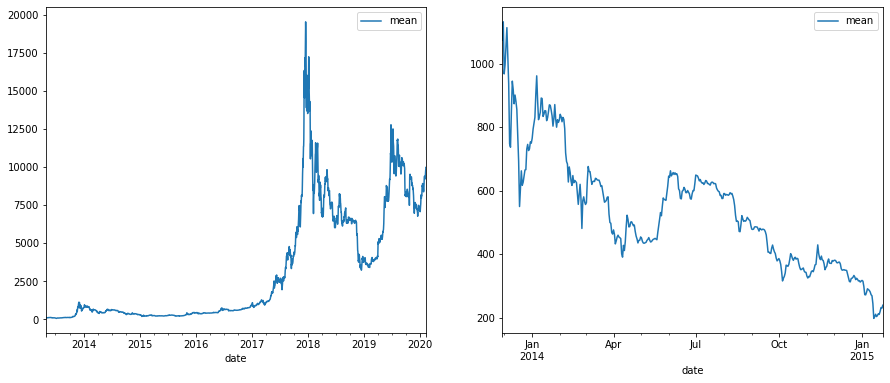

In [11]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

# all time
bitcoin_data.plot(
    x = 'date',
    y = 'mean',
    ax = ax1
)

# time window of observations
bitcoin_data.loc[observation_period].plot(
    x = 'date',
    y = 'mean',
    ax = ax2
)

plt.show()